# UFC Automated Scoring

The goal of this notebook is to:
* Read in stored, scraped UFC data and convert it into a dataset ready for ML models
* Train, test, and analyze ML models

Functional as of April 2021

## Read in stored data

In [1]:
import numpy as np
import pandas as pd

In [2]:
STORED_FIGHT_TABLE = pd.read_csv('data/April_22_2021_better_data/FIGHT_TABLE_NUM_EVENTS_All_DATA_MODE_Summary_22-04-2021_11:08:22.csv')

In [3]:
STORED_FIGHT_TABLE

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,150,62,52.0,29.0,169,70,4,1,...,22,13,138,59,5,3,7,0,0,U-DEC
1,0,0,105,88,47.0,45.0,109,99,0,0,...,25,17,103,84,2,4,0,0,0,U-DEC
2,0,0,21,27,44.0,49.0,32,91,0,8,...,1,1,14,18,5,3,2,6,1,U-DEC
3,0,1,66,55,58.0,46.0,84,72,3,0,...,7,17,39,50,7,4,20,1,0,S-DEC
4,0,0,90,80,46.0,47.0,90,82,0,4,...,4,20,88,77,2,3,0,0,0,S-DEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5888,2,0,24,16,68.0,33.0,49,31,0,1,...,12,0,17,7,4,4,3,5,0,KO/TKO Punch
5889,0,0,19,24,55.0,55.0,95,145,1,2,...,5,2,4,1,15,23,0,0,0,S-DEC
5890,0,0,14,13,35.0,19.0,30,15,3,0,...,3,0,11,12,0,1,3,0,0,U-DEC
5891,0,0,9,3,56.0,60.0,17,11,1,0,...,2,0,2,0,5,3,2,0,0,SUB Guillotine Choke


In [4]:
X = STORED_FIGHT_TABLE.drop(['Winner', 'Fighter 0 Name', 'Fighter 1 Name', 'Method'], axis=1).fillna(0)
y = STORED_FIGHT_TABLE[['Winner']]

In [5]:
X.head()

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
0,0,0,150,62,52.0,29.0,169,70,4,1,...,13,7,22,13,138,59,5,3,7,0
1,0,0,105,88,47.0,45.0,109,99,0,0,...,26,16,25,17,103,84,2,4,0,0
2,0,0,21,27,44.0,49.0,32,91,0,8,...,9,2,1,1,14,18,5,3,2,6
3,0,1,66,55,58.0,46.0,84,72,3,0,...,19,8,7,17,39,50,7,4,20,1
4,0,0,90,80,46.0,47.0,90,82,0,4,...,12,20,4,20,88,77,2,3,0,0


In [6]:
y.head()

,Winner
0,0
1,0
2,1
3,0
4,0


## Setup train/validate/test split with data augmentation

TODO: Add in smarter data augmentation that create new datapoints nearby.

In [7]:
def create_flipped_table(table):
    '''Rearranges columns of table so that each fight has two rows. Let fighters be A and B.
       One row has (Fighter 0 = A, Fighter 1 = B). One row has (Fighter 0 = B, Fighter 1 = A)
       Ensure same column order, as column names not looked at when passed to ML model'''

    # Get columns in flipped order, which moves the columns around, but changes column name order too
    flipped_columns = []
    for column in table.columns:
        if "Fighter 0" in column:
            flipped_columns.append(column.replace("Fighter 0", "Fighter 1"))
        elif "Fighter 1" in column:
            flipped_columns.append(column.replace("Fighter 1", "Fighter 0"))
        else:
            flipped_columns.append(column)
    flipped_table = table[flipped_columns]

    # Flips winners around
    if 'Winner' in flipped_table.columns:
         flipped_table['Winner'] = flipped_table['Winner'].replace([0, 1], [1, 0])

    # Change column names back to normal
    flipped_table.columns = table.columns
    return flipped_table


def add_rows_of_flipped_columns(table):
    flipped_table = create_flipped_table(table)
    new_table = pd.concat([table, flipped_table])
    return new_table

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=0)
X_train, y_train = add_rows_of_flipped_columns(X_train), add_rows_of_flipped_columns(y_train)
X_valid, y_valid = add_rows_of_flipped_columns(X_valid), add_rows_of_flipped_columns(y_valid)
X_test, y_test = add_rows_of_flipped_columns(X_test), add_rows_of_flipped_columns(y_test)

In [9]:
# Expect equal number of examples in Fighter 0 as Fighter 1
assert(len(y_train[y_train['Winner'] == 0]) == len(y_train[y_train['Winner'] == 1]))
assert(len(y_valid[y_valid['Winner'] == 0]) == len(y_valid[y_valid['Winner'] == 1]))
assert(len(y_test[y_test['Winner'] == 0]) == len(y_test[y_test['Winner'] == 1]))

In [10]:
X_train.head()

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,...,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
5815,0,0,2,2,33.0,22.0,23,11,1,0,...,2,1,0,0,0,0,0,1,2,1
4187,0,0,16,55,41.0,54.0,30,109,1,4,...,6,9,2,19,9,20,6,10,1,25
4117,1,0,2,3,50.0,37.0,3,3,0,0,...,1,3,0,0,2,3,0,0,0,0
2096,0,0,20,9,39.0,26.0,27,38,1,6,...,4,3,9,1,12,4,1,1,7,4
4158,0,0,36,67,46.0,50.0,91,78,5,0,...,6,12,10,2,17,61,3,3,16,3


In [11]:
y_train.head()

,Winner
5815,0
4187,1
4117,0
2096,1
4158,0


In [12]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_valid.shape = {X_valid.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_valid.shape = {y_valid.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (5290, 30)
X_valid.shape = (2606, 30)
X_test.shape = (3890, 30)
y_train.shape = (5290, 1)
y_valid.shape = (2606, 1)
y_test.shape = (3890, 1)


## Train and test ML models

### Random forest

/home/tylerlum/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
In /home/tylerlum/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/tylerlum/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/tylerlum/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/tylerlum/.local/lib/python3.6/site-packages

accuracy_train = 0.8674858223062382
accuracy_valid = 0.8445894090560245


<BarContainer object of 30 artists>

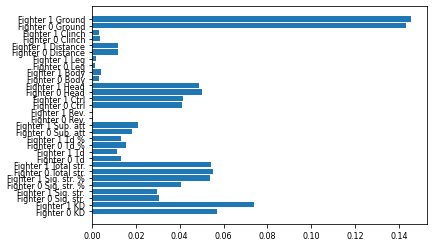

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Train
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

# Validate
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, clf.feature_importances_)

### MLP

In [16]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/home/tylerlum/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


accuracy_train = 0.8833648393194707
accuracy_valid = 0.8434382194934766


### SVM

In [18]:
# SVM
from sklearn.svm import SVC

clf = SVC(random_state=1).fit(X_train, y_train)
accuracy_train = clf.score(X_train, y_train)
accuracy_valid = clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/home/tylerlum/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


accuracy_train = 0.8196597353497165
accuracy_valid = 0.8081350729086723


### Deep model

In [14]:
import tensorflow as tf

/home/tylerlum/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tylerlum/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tylerlum/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tylerlum/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [21]:
# FFN
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=X_train.shape[1:]))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,081
Trainable params: 2,081
Non-trainable params: 0
_________________________________________________________________


In [200]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))
model.evaluate(X_train, y_train)
model.evaluate(X_valid, y_valid)

Train on 5290 samples, validate on 2606 samples
Epoch 1/100
5290/5290 [==============================] - 0s 29us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 2/100
5290/5290 [==============================] - 0s 27us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 3/100
5290/5290 [==============================] - 0s 28us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 4/100
5290/5290 [==============================] - 0s 28us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 5/100
5290/5290 [==============================] - 0s 38us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 6/100
5290/5290 [==============================] - 0s 35us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 7/100
5290/5290 [==============================] - 0s 30us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - va

5290/5290 [==============================] - 0s 28us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 60/100
5290/5290 [==============================] - 0s 30us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 61/100
5290/5290 [==============================] - 0s 27us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 62/100
5290/5290 [==============================] - 0s 27us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 63/100
5290/5290 [==============================] - 0s 27us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 64/100
5290/5290 [==============================] - 0s 29us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 65/100
5290/5290 [==============================] - 0s 26us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 66/100
5290/5290 [================

[6.314620178658872, 0.6799693]

In [185]:
from tensorflow.keras.layers import Input, Lambda, Subtract, Activation
from tensorflow.keras.models import Model
def create_comparison_model(input_shape):
    num_features_per_fighter = input_shape[0] // 2

    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=num_features_per_fighter))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    
    # Run cnn model on each frame
    input_tensor = Input(shape=input_shape)
    fighter0_state = Lambda(lambda x: x[:, :num_features_per_fighter], name='fighter0_state')(input_tensor)
    fighter1_state = Lambda(lambda x: x[:, num_features_per_fighter:], name='fighter1_state')(input_tensor)

#     fighter0_score = model(fighter0_state)
#     fighter1_score = model(fighter1_state)
    fighter0_score = Lambda(lambda x: model(x), name='fighter0_score')(fighter0_state)
    fighter1_score = Lambda(lambda x: model(x), name='fighter1_score')(fighter1_state)
    
    difference_score = Subtract(name='subtracter')([fighter1_score, fighter0_score])
    prediction = Activation('sigmoid')(difference_score)
    return Model(inputs=input_tensor, outputs=prediction)

In [186]:
model = create_comparison_model(X.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
fighter1_state (Lambda)         (None, 15)           0           input_45[0][0]                   
__________________________________________________________________________________________________
fighter0_state (Lambda)         (None, 15)           0           input_45[0][0]                   
__________________________________________________________________________________________________
fighter1_score (Lambda)         (None, 1)            0           fighter1_state[0][0]             
___________________________________________________________________________________________

In [187]:
X_train.head()

,Fighter 0 KD,Fighter 0 Sig. str.,Fighter 0 Sig. str. %,Fighter 0 Total str.,Fighter 0 Td,Fighter 0 Td %,Fighter 0 Sub. att,Fighter 0 Rev.,Fighter 0 Ctrl,Fighter 0 Head,...,Fighter 1 Td %,Fighter 1 Sub. att,Fighter 1 Rev.,Fighter 1 Ctrl,Fighter 1 Head,Fighter 1 Body,Fighter 1 Leg,Fighter 1 Distance,Fighter 1 Clinch,Fighter 1 Ground
5815,0,2,33.0,23,1,50.0,1,0,215.0,0,...,0.0,0,0,0.0,1,1,0,0,1,1
4187,0,16,41.0,30,1,25.0,0,0,21.0,8,...,44.0,0,0,527.0,27,9,19,20,10,25
4117,1,2,50.0,3,0,0.0,0,0,2.0,1,...,0.0,0,0,0.0,0,3,0,3,0,0
2096,0,20,39.0,27,1,33.0,0,0,204.0,7,...,46.0,0,0,429.0,5,3,1,4,1,4
4158,0,36,46.0,91,5,38.0,1,1,485.0,20,...,0.0,0,1,48.0,53,12,2,61,3,3


In [188]:
fighter0_columns = [col for col in X_train.columns if "Fighter 0" in col]
fighter1_columns = [col for col in X_train.columns if "Fighter 1" in col]
print(f"fighter0_columns = {fighter0_columns}")
print(f"fighter1_columns = {fighter1_columns}")
new_columns = fighter0_columns + fighter1_columns

fighter0_columns = ['Fighter 0 KD', 'Fighter 0 Sig. str.', 'Fighter 0 Sig. str. %', 'Fighter 0 Total str.', 'Fighter 0 Td', 'Fighter 0 Td %', 'Fighter 0 Sub. att', 'Fighter 0 Rev.', 'Fighter 0 Ctrl', 'Fighter 0 Head', 'Fighter 0 Body', 'Fighter 0 Leg', 'Fighter 0 Distance', 'Fighter 0 Clinch', 'Fighter 0 Ground']
fighter1_columns = ['Fighter 1 KD', 'Fighter 1 Sig. str.', 'Fighter 1 Sig. str. %', 'Fighter 1 Total str.', 'Fighter 1 Td', 'Fighter 1 Td %', 'Fighter 1 Sub. att', 'Fighter 1 Rev.', 'Fighter 1 Ctrl', 'Fighter 1 Head', 'Fighter 1 Body', 'Fighter 1 Leg', 'Fighter 1 Distance', 'Fighter 1 Clinch', 'Fighter 1 Ground']


In [189]:
X_train = X_train[new_columns]
X_valid = X_valid[new_columns]
X_test = X_test[new_columns]

In [190]:
X_train.head()

,Fighter 0 KD,Fighter 0 Sig. str.,Fighter 0 Sig. str. %,Fighter 0 Total str.,Fighter 0 Td,Fighter 0 Td %,Fighter 0 Sub. att,Fighter 0 Rev.,Fighter 0 Ctrl,Fighter 0 Head,...,Fighter 1 Td %,Fighter 1 Sub. att,Fighter 1 Rev.,Fighter 1 Ctrl,Fighter 1 Head,Fighter 1 Body,Fighter 1 Leg,Fighter 1 Distance,Fighter 1 Clinch,Fighter 1 Ground
5815,0,2,33.0,23,1,50.0,1,0,215.0,0,...,0.0,0,0,0.0,1,1,0,0,1,1
4187,0,16,41.0,30,1,25.0,0,0,21.0,8,...,44.0,0,0,527.0,27,9,19,20,10,25
4117,1,2,50.0,3,0,0.0,0,0,2.0,1,...,0.0,0,0,0.0,0,3,0,3,0,0
2096,0,20,39.0,27,1,33.0,0,0,204.0,7,...,46.0,0,0,429.0,5,3,1,4,1,4
4158,0,36,46.0,91,5,38.0,1,1,485.0,20,...,0.0,0,1,48.0,53,12,2,61,3,3


In [191]:
H = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))
model.evaluate(X_train, y_train)
model.evaluate(X_valid, y_valid)

Train on 5290 samples, validate on 2606 samples
Epoch 1/100
5290/5290 [==============================] - 0s 63us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 2/100
5290/5290 [==============================] - 0s 30us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 3/100
5290/5290 [==============================] - 0s 29us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 4/100
5290/5290 [==============================] - 0s 28us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 5/100
5290/5290 [==============================] - 0s 27us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 6/100
5290/5290 [==============================] - 0s 27us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 7/100
5290/5290 [==============================] - 0s 27us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - va

5290/5290 [==============================] - 0s 28us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 60/100
5290/5290 [==============================] - 0s 29us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 61/100
5290/5290 [==============================] - 0s 30us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 62/100
5290/5290 [==============================] - 0s 29us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 63/100
5290/5290 [==============================] - 0s 28us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 64/100
5290/5290 [==============================] - 0s 30us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 65/100
5290/5290 [==============================] - 0s 31us/sample - loss: 6.0988 - acc: 0.6888 - val_loss: 6.3146 - val_acc: 0.6800
Epoch 66/100
5290/5290 [================

[6.314620178658872, 0.6799693]

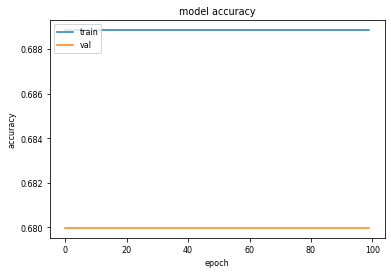

In [192]:
from matplotlib import pyplot as plt
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [193]:
model.predict(X_test[4:10])

array([[0.87108403],
       [0.00519111],
       [0.8157942 ],
       [0.9843017 ],
       [0.97545844],
       [0.        ]], dtype=float32)

In [194]:
y_test[4:10]

,Winner
4465,0
5560,0
170,0
4271,0
675,1
214,1


In [195]:
subtracter = model.get_layer('subtracter').output
subtracter = Model(model.input, subtracter)
subtracter.predict(X_test[4:10])

array([[  1.9105778],
       [ -5.2556033],
       [  1.4881086],
       [  4.138381 ],
       [  3.6825416],
       [-64.87514  ]], dtype=float32)

In [196]:
fighter0_score = model.get_layer('fighter0_score').output
fighter0_score = Model(model.input, fighter0_score)
fighter0_score.predict(X_test[4:10])

array([[ 7.386635 ],
       [ 6.7008905],
       [13.954484 ],
       [14.486899 ],
       [ 2.45319  ],
       [79.68411  ]], dtype=float32)

In [197]:
fighter1_score = model.get_layer('fighter1_score').output
fighter1_score = Model(model.input, fighter1_score)
fighter1_score.predict(X_test[4:10])

array([[ 9.297213 ],
       [ 1.4452873],
       [15.442593 ],
       [18.62528  ],
       [ 6.1357317],
       [14.808975 ]], dtype=float32)